## mnist手写数字识别

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# 如果MNIST_data不存在会先下载再读入，pytorch的数据集和这个不一样。
mnist = input_data.read_data_sets('./MNIST_data',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# 28*28*1 灰度图被拉成一行了
mnist.train.images.shape

(55000, 784)

In [4]:
mnist.test.images.shape

(10000, 784)

In [5]:
# 验证集
mnist.validation.images.shape

(5000, 784)

In [6]:
# 循环读，共55000张
train_x,train_y = mnist.train.next_batch(20000)

In [7]:
train_x.shape

(20000, 784)

In [8]:
# 测试集
test_x, test_y = mnist.test.next_batch(5000)

## 图像的可视化

In [9]:
import matplotlib.pyplot as plt

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


<function matplotlib.pyplot.show(*args, **kw)>

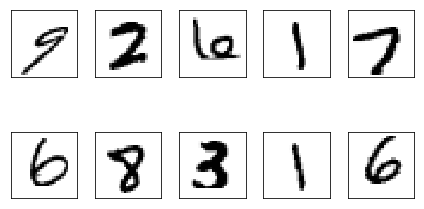

In [10]:
plt.rc('image',cmap='binary')
for i in range(10):#打印10张图
    plt.subplot(2,5,i+1)
    # 打印图用imshow
    plt.imshow(train_x[i].reshape(28,28))
    print(train_y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show

## 全连接神经网络

In [11]:
# Sequential 相当于pipeline，会自动执行forward和bp
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [12]:
def model1():
    model=Sequential()
    model.add(Dense(784,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy')
    return model

In [13]:
m = model1()

In [14]:
# m.summary()

In [15]:
history = m.fit(train_x,train_y,epochs=10,batch_size=32)

Epoch 1/10
20000/20000 [==============================] - 10s 507us/step - loss: 0.3189
Epoch 2/10
20000/20000 [==============================] - 9s 451us/step - loss: 0.1244
Epoch 3/10
20000/20000 [==============================] - 9s 467us/step - loss: 0.0849
Epoch 4/10
20000/20000 [==============================] - 9s 458us/step - loss: 0.0579
Epoch 5/10
20000/20000 [==============================] - 9s 460us/step - loss: 0.0424
Epoch 6/10
20000/20000 [==============================] - 9s 456us/step - loss: 0.0365
Epoch 7/10
20000/20000 [==============================] - 9s 460us/step - loss: 0.0360
Epoch 8/10
20000/20000 [==============================] - 9s 455us/step - loss: 0.0287
Epoch 9/10
20000/20000 [==============================] - 9s 454us/step - loss: 0.0231
Epoch 10/10
20000/20000 [==============================] - 10s 480us/step - loss: 0.0180


In [16]:
pred = m.predict(test_x)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(pred.argmax(1),test_y.argmax(1))

0.9716

## 卷积神经网络

In [19]:
import os 
import random
import numpy as np 

In [20]:
model_dir='models'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

## LeNet

In [21]:
# 不像TensorFlow一样有GPU和CPU版本，安装的时候pytorch会自动识别CPU还是GPU
import torch
# nn就是各种层
import torch.nn as nn
import torch.nn.functional as F
# optim是优化器
import torch.optim as optim
# torchvision有optim的一些东西
import torchvision
# trainsforms相当于pipeline
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [22]:
# # 定一个transforms
# # compose相当于一个pipeline，链式调用
# data_trans = transforms.Compose([
#     transforms.Resize(32),   # resize是防止在多层网络中图像提前变成1*1
#     transforms.ToTensor()
# #    transforms.Normalize(()())?<-参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
# ])

## 图像的Normalize

- 目的：将图片进行归一化的缩放|(x-mean)/std
    - 如果不归一化，可能导致梯度爆炸或者梯度衰减、梯度为零。矩阵是相乘的，网络越深，连乘越多。如果梯度都大于1就会越乘越大，导致梯度爆炸，上溢出；如果梯度小于1，会越来越小，最终导致梯度为0，梯度离散，相当于平滩底部，学不到什么东西。

- 思考：图片归一化后，真的不存在小于0或者大于1的outlier了吗？
    - 不一定，如果数据不均匀，可能导致小于0或者大于1的数据。归一化的公式？

- 思考：归一化哪部分数据？
    - A 训练集 B 评测集 C 训练集+评测集？     A
    - 不可能得到全部数据。

In [23]:
np.mean(mnist.train.images)

0.13070032

In [24]:
np.std(mnist.train.images)

0.30815914

In [25]:
data_trans = transforms.Compose([
    transforms.Resize(32),   # 防止提前出现1*1像素的图像
    transforms.ToTensor(),   # 数据结构转换成torch能接收的
    transforms.Normalize((0.1307,),(0.3081,))  # 参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [26]:
# 会建立一个data目录，train是否是训练集。
train_data = datasets.MNIST('data', train=True, download=True, transform=data_trans)
test_data = datasets.MNIST('data', train=False, download=True, transform=data_trans)

In [27]:
n_train = int(len(train_data)*0.9)
n_validation = len(train_data)-n_train    # 10%做评测集

In [28]:
train_data,valid_data = torch.utils.data.random_split(train_data,[n_train,n_validation])

In [29]:
print(len(train_data),len(valid_data),len(test_data))

54000 6000 10000


In [31]:
batch_size=64

- 目前完成了数据集的制作

In [32]:
# iterator 相当于pytorch里面的一个object，对数据进行切分之后的数据结构。只有训练集有必要shuffle。
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [35]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        #第一层conv1卷积层，in_channel=1,output_channel=6,kernel_size=5*5,input_size=32*32,output_size=28*28
        self.conv1=nn.Conv2d(1,6,5)
        #第二层conv2，output_channel=6 ,kernel 5*5,output_size=10*10,input_size=14*14
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,80)
        self.fc3=nn.Linear(80,10)#不用增加softmax层，在cross_entropy的Loss中自动增加了Softmax
        
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(x.shape[0],-1)  #？
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

- 到此神经网络定义完毕

## 载入模型并训练

In [36]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
device

device(type='cpu')

In [38]:
model=LeNet().to(device)

In [39]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

In [40]:
optimizer=optim.Adam(model.parameters())   # 优化器

In [41]:
criterion=nn.CrossEntropyLoss()    # loss

## 如何评价
- 计算精确度

In [42]:
def accu(fx,y):
    pred=fx.max(1,keepdim=True)[1]
    correct=pred.eq(y.view_as(pred)).sum()#得到该batch的准确度
    acc=correct.float()/pred.shape[0]
    return acc

In [43]:
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0#积累变量
    epoch_acc=0#积累变量
    model.train()#该函数表示PHASE=Train
    
    for (x,y) in iterator:#拿去每一个minibatch
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        fx=model(x)#进行forward
        loss=criterion(fx,y)#计算Loss,train_loss
        type(loss)
        acc=accu(fx,y)#计算精确度，train_accu
        loss.backward()#进行BP
        optimizer.step()#统一更新模型
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [44]:
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

## 开始训练

In [45]:
epochs=10
model_path=os.path.join(model_dir,'lenet_mnist.pt')

In [46]:
best_valid_loss=float('inf')

In [47]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:0.24576564233140993|Train Acc:0.9252443720379147|Val Loss:0.10026893629989725|Val Acc:0.9699689714198417
Epoch:2|Train Loss:0.07282023004287086|Train Acc:0.9774387835467596|Val Loss:0.058544988308022634|Val Acc:0.982491134963137
Epoch:3|Train Loss:0.05119644594047731|Train Acc:0.9840355944153257|Val Loss:0.057960785568711606|Val Acc:0.9812721629092034
Epoch:4|Train Loss:0.03853387127837864|Train Acc:0.987509873594153|Val Loss:0.05738091207248099|Val Acc:0.982491134963137
Epoch:5|Train Loss:0.030649784546327816|Train Acc:0.9901880924170616|Val Loss:0.04693268120605895|Val Acc:0.9859264182283524
Epoch:6|Train Loss:0.02556110729388363|Train Acc:0.9915580568720379|Val Loss:0.055865582276849034|Val Acc:0.9846520392184562
Epoch:7|Train Loss:0.023265178518378622|Train Acc:0.9920332247470792|Val Loss:0.04867440676118465|Val Acc:0.9862034574468085
Epoch:8|Train Loss:0.019254651971126056|Train Acc:0.9937611078199052|Val Loss:0.04479673015389671|Val Acc:0.9874224288666502
Epoch

In [48]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, device, test_iterator, criterion)

print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.03467386759295585 | Test Acc: 0.9895501592356688 |


## AlexNet

In [49]:
torch.set_num_threads(100)

In [50]:
data_trans_alexnet = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])
train_data = datasets.MNIST('data',train=True,download=True,transform=data_trans_alexnet)
test_data = datasets.MNIST('data',train=False,download=True,transform=data_trans_alexnet)

In [51]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train

In [52]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [53]:
print(len(train_data),len(valid_data),len(test_data))

54000 6000 10000


In [54]:
batch_size = 64

In [55]:
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [56]:
class AlexNet(nn.Module):
    def __init__(self):#init函数定义的是网络的架构、关键的网络模块、模组
        super(AlexNet,self).__init__()
        self.feature_block=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.class_block=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,10),
        )
    def forward(self,x):#数据的正向流
        x = self.feature_block(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),256*6*6)
        x = self.class_block(x)
        return x

In [57]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu:0')

In [58]:
model = AlexNet().to(device)

In [59]:
model

AlexNet(
  (feature_block): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (class_block): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dro

In [60]:
optimizer=optim.Adam(model.parameters())

In [61]:
criterion=nn.CrossEntropyLoss()

In [62]:
epochs=10
model_dir='models'
model_path=os.path.join(model_dir,'alexnet_mnist.pt')

In [63]:
best_valid_loss=float('inf')

In [64]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:0.30664038052561726|Train Acc:0.8991595082938388|Val Loss:0.08289378956752888|Val Acc:0.9756205671645225
Epoch:2|Train Loss:0.10010198266929572|Train Acc:0.971187549391629|Val Loss:0.06561374834718857|Val Acc:0.9792774820581396
Epoch:3|Train Loss:0.08785877900939629|Train Acc:0.9756491903868897|Val Loss:0.04346287076143508|Val Acc:0.9876440604950519
Epoch:4|Train Loss:0.07618335289527525|Train Acc:0.9781484498655627|Val Loss:0.06057419275191236|Val Acc:0.9832668437602672
Epoch:5|Train Loss:0.06757545198636103|Train Acc:0.9812524683808829|Val Loss:0.04482662555900343|Val Acc:0.9863696808510638
Epoch:6|Train Loss:0.06108327877985852|Train Acc:0.9829803515243304|Val Loss:0.050641411875790736|Val Acc:0.9870899820581396
Epoch:7|Train Loss:0.05734411653426975|Train Acc:0.9843935130331753|Val Loss:0.041215979949908055|Val Acc:0.9876994680851063


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load(model_path))
test_loss, test_acc = evaluate(model, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

In [ ]:
torch.__version__

In [ ]:
torchvision.__version__

In [130]:
torch.get_num_threads()

100